# Search inside astroquery catalog


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/05/17
- last update : 
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

https://astroquery.readthedocs.io/en/latest/

## Import

In [1]:
import os,sys,re
import h5py
from astropy.table import Table
import random

In [2]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
WL_BALMER_BREAK= 3646.0 
NQUANTILES = 10
quantiles = np.linspace(0,1,NQUANTILES+1)
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [7]:
FLAG_REMOVE_RMAG0 = False

## Start

In [8]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Volumes/Backup2020/MacOSX/GitHub/LSST/PhotoZ_PhD/QueryCatalogs


In [9]:
with h5py.File('SLspectra.hdf5', 'r') as hf:
    data_in = hf['flambda'][:]
    wl_in = hf['wl'][:]
    target = hf['quantile'][:]

    # other data
    redshift = hf['redshift'][:]
    Rmag = hf['Rmag'][:]
    RT = hf['RT'][:]
    RV = hf['RV'][:]
    ra = hf['ra'][:]
    dec = hf['dec'][:]
    fracinfbalmer = hf['fracinfbalmer'][:]


In [10]:
spectra = data_in
wavelengths = wl_in

# Read all SEDS and noremalised them in a range 0 - 10000 nm and interpolate

## Position of SL galaxies vs redshifts

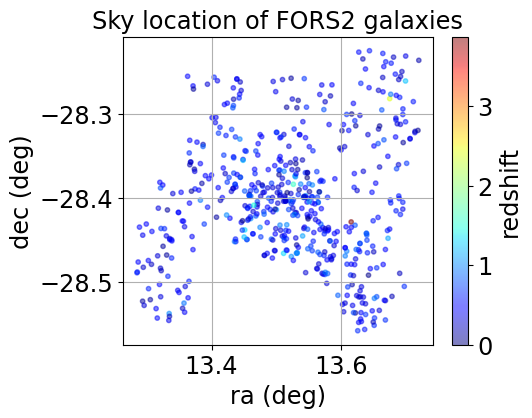

In [11]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
#im = ax.scatter(all_ra,all_dec,c=all_colors2,s=10,marker="o",alpha=0.5,cmap=jet2)
im = ax.scatter(ra,dec,c=redshift,s=10,marker="o",alpha=0.5,cmap="jet")
ax.grid()
ax.set_xlabel("ra (deg)")
ax.set_ylabel("dec (deg)")
ax.set_title("Sky location of FORS2 galaxies")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('redshift')

## Position vs Redshift

Text(0.5, 0.98, 'redshift')

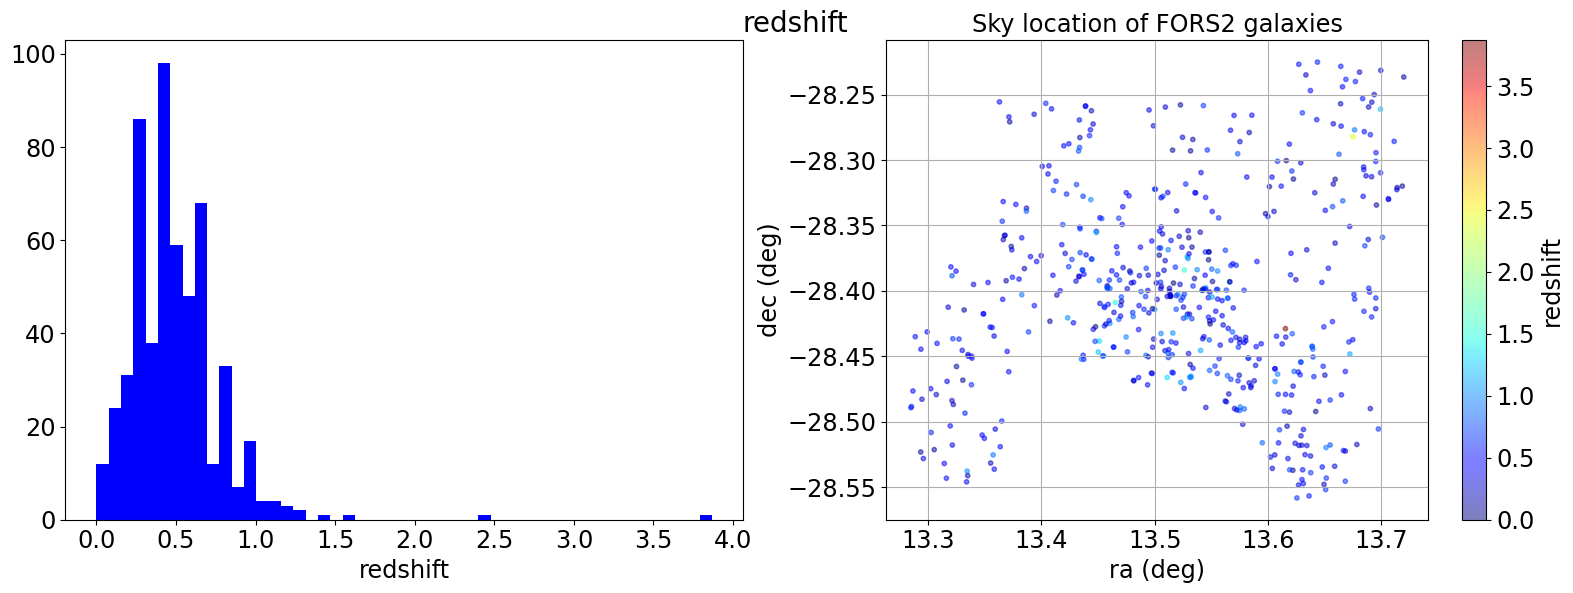

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(redshift,bins=50,facecolor="b");
        ax.set_xlabel("redshift")
    else:
        im = ax.scatter(ra,dec,c=redshift,s=10,marker="o",alpha=0.5,cmap="jet")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('redshift')
        ax.grid()
        ax.set_xlabel("ra (deg)")
        ax.set_ylabel("dec (deg)")
        ax.set_title("Sky location of FORS2 galaxies")
        #fig.colorbar(im, ax=ax)
plt.tight_layout()  
plt.suptitle("redshift",fontsize=20)

In [13]:
index_selected=np.where(redshift<1)[0]

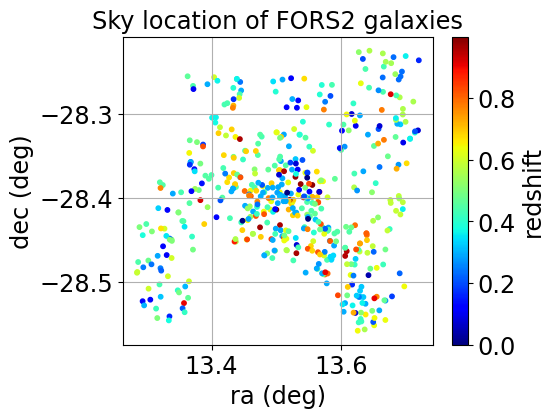

In [14]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
#im = ax.scatter(all_ra,all_dec,c=all_colors2,s=10,marker="o",alpha=0.5,cmap=jet2)
im = ax.scatter(ra[index_selected],dec[index_selected],c=redshift[index_selected],s=10,marker="o",alpha=1,cmap="jet")
ax.grid()
ax.set_xlabel("ra (deg)")
ax.set_ylabel("dec (deg)")
ax.set_title("Sky location of FORS2 galaxies")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('redshift')

In [15]:
ra.mean()

13.522064

In [16]:
dec.mean()

-28.401812

## Position of galaxies vs Rmag

Text(0.5, 0.98, 'Rmag')

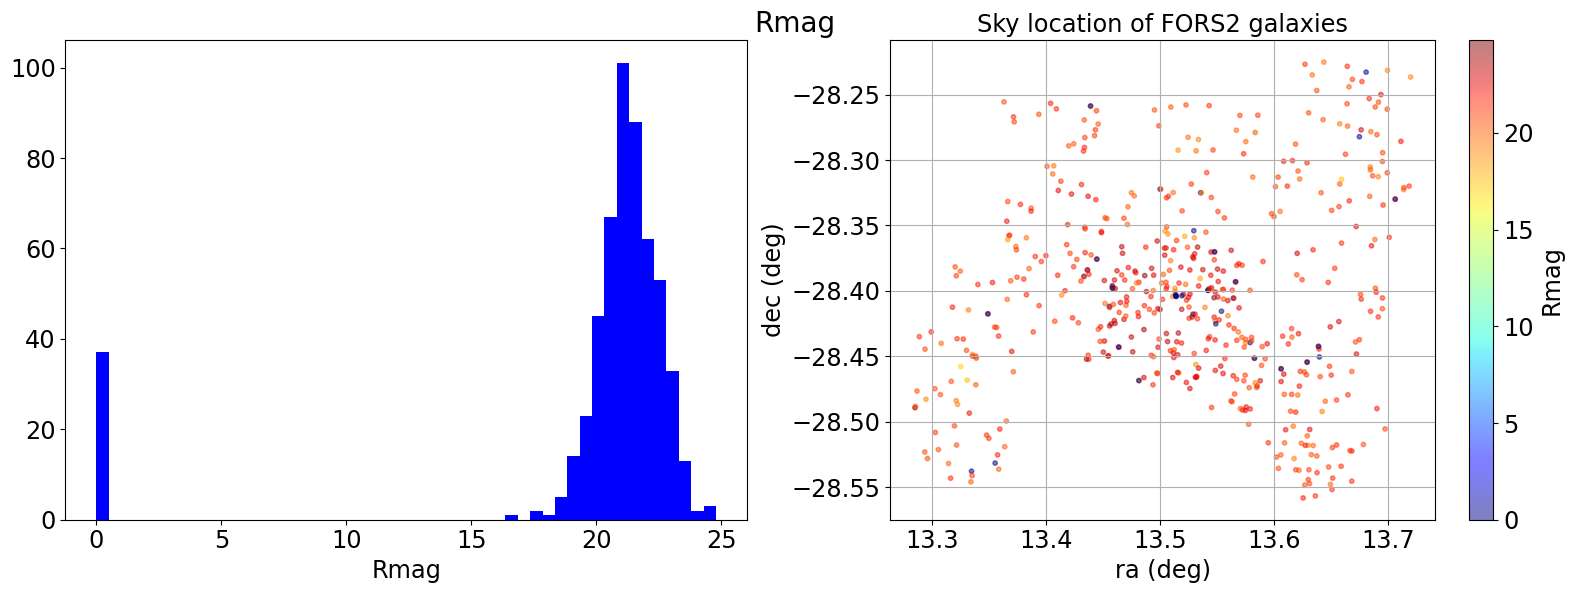

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(Rmag,bins=50,facecolor="b");
        ax.set_xlabel("Rmag")
    else:
        im = ax.scatter(ra,dec,c=Rmag,s=10,marker="o",alpha=0.5,cmap="jet")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Rmag')
        ax.grid()
        ax.set_xlabel("ra (deg)")
        ax.set_ylabel("dec (deg)")
        ax.set_title("Sky location of FORS2 galaxies")
        #fig.colorbar(im, ax=ax)
plt.tight_layout() 
plt.suptitle("Rmag",fontsize=20)

In [18]:
from astroquery.image_cutouts.first import First

from astropy import coordinates

from astropy import units as u

image = First.get_images(coordinates.SkyCoord(ra.mean()*u.deg, dec.mean()*u.deg,frame='icrs'))

image

ModuleNotFoundError: No module named 'astroquery'